Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Catch up, if needed
- [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2/portfolio-project/ds6), then choose your dataset, and [submit this form](https://forms.gle/nyWURUg65x1UTRNV9), due yesterday at 3:59pm Pacific.
- Submit predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file.) The competition closes today at 3:59pm. Every student should make at least one submission that scores at least 60% accuracy (above the majority class baseline).

## Assignment
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_ The competition closes today at 3:59pm.
- [ ] Add comments and Markdown to your notebook. Clean up your code.
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Try combining xgboost early stopping, cross-validation, & hyperparameter optimization, with [the "original" (non scikit-learn) xgboost API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.cv).
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?

#### Try stacking multiple submissions!

Here's some code you can use:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
# Change into directory for module
!rm -rf eda.py
!wget https://raw.githubusercontent.com/hurshd0/ds-cheat-sheets/master/eda.py

--2019-08-15 21:59:41--  https://raw.githubusercontent.com/hurshd0/ds-cheat-sheets/master/eda.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17454 (17K) [text/plain]
Saving to: ‘eda.py’

eda.py              100%[===================>]  17.04K  --.-KB/s    in 0.01s   

2019-08-15 21:59:46 (1.59 MB/s) - ‘eda.py’ saved [17454/17454]



In [17]:
################################ EDA IMPORTS ###################################
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
# import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions
# ---------------- Plot libs settings ------------- #
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# --------------------- Custom lib imports --------------#
import eda

# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

#################################### ML IMPORTS ################################
### Pre-Processing
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

### Train/Test - Split & CV
from sklearn.model_selection import train_test_split

### Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Post-processing
from sklearn.pipeline import make_pipeline

################################################################################

In [18]:
def load_dataset():
    train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
    test = pd.read_csv('../data/tanzania/test_features.csv')
    sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')
    print(f'''
    -------------------- SHAPE ---------------------
    Train Set: {train.shape}
    Test Set: {test.shape}
    Sample Submission: {sample_submission.shape}
    ------------------------------------------------
    ''')
    return (train, test, sample_submission)
traindf, testdf, sampledf = load_dataset()


    -------------------- SHAPE ---------------------
    Train Set: (59400, 41)
    Test Set: (14358, 40)
    Sample Submission: (14358, 2)
    ------------------------------------------------
    


In [19]:
def kaggle_submission(model, X_test, submission, prefix=None):
    import datetime, sys
    in_colab = 'google.colab' in sys.modules
    y_pred = model.predict(X_test)
    submission['status_group'] = y_pred
    if prefix:
        file_name = 'submission-{}-{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d'), prefix)
    else:
        file_name = 'submission-{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d'))
    submission.to_csv(file_name, index=False)
    if in_colab:
        from google.colab import files
        # Just try again if you get this error:
        # TypeError: Failed to fetch
        # https://github.com/googlecolab/colabtools/issues/337
        try:
            files.download(file_name)
        except Exception as e:
            print('Try it again if you get: Type Error: NetworkError when attempting to fetch resource.')
            print(e)

In [20]:
def wrangle(df, set_id_as_index=False, add_years_since=False, drop_cols=False, clean_cat_cols=False, 
            clean_num_cols=False, fix_null_island=False, 
            num_missing_value_feature=False, cat_missing_value_feature=False, convert_lat_lon=False, 
            cut_construction_year=False,
            cut_gps_height=False):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    df = df.copy()
    
    if set_id_as_index:
        # Set `id` to be the index
        df = df.set_index('id', drop=True)
    
    if add_years_since:
        # Set correct data type for 
        ## - datetime columns
        df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
        df['year_recorded'] = df['date_recorded'].dt.year
        df['month_recorded'] = df['date_recorded'].dt.month
        df['day_recorded'] = df['date_recorded'].dt.day
        # Create feature
        # Add last_inspeaction_year and years_since_construction
        df['years_since'] = df['year_recorded'] - df['construction_year']
        

    if drop_cols:
        # Drop cols
        useless_columns = ['date_recorded', 'recorded_by', 'quantity_group', 'num_private', 'payment_type']
        # Remove duplicate columns and useless one
        df = df.drop(useless_columns, axis=1)
    
    if clean_cat_cols:
        # Sanitize categorical columns
        categorical_columns = eda.get_categorical_columns(df)
        nan_labels = ['unknown', 'none', '0']
        exclude_cols = ['public_meeting', 'permit']
        categorical_columns = [col for col in categorical_columns if col not in exclude_cols]
        for col in categorical_columns:
            df[col] = df[col].str.strip().str.lower()
            df[col] = df[col].replace(nan_labels, np.NaN)
    
    if fix_null_island:
        # Fix Null Island - latitudes and longitudes
        null_island = {'longitude':0, 'latitude':-2e-8}
        mask = (df['longitude'] == null_island['longitude']) & (df['latitude'] == null_island['latitude'])
        loc = 'region'
        locs = df.loc[mask, loc].unique()
        for k in null_island.keys():
            for loc_name in locs:
                df.loc[mask & (df[loc] == loc_name), k] = df[~mask].groupby(loc)[k].mean()[loc_name]
    
    if clean_num_cols:
        # Clean numerical columns
        null_placeholders = {'amount_tsh':0, 'gps_height':0, 'population':0, 'construction_year':0}
        for col, null_val in null_placeholders.items():
            df[col] = df[col].replace(null_val, np.NaN)
    
    if num_missing_value_feature:
        # Add MISSING value feature for numerical columns    
        cols_with_zeros = ['amount_tsh', 'gps_height', 'construction_year', 'years_since',
                           'population']
        for col in cols_with_zeros:
            df[col+'_MISSING'] = (df[col].isnull()).astype(int)
    
    if cat_missing_value_feature:
        # Add MISSING value feature for categorical columns
        cols_with_zeros = ['construction_year', 'years_since',
                       'gps_height', 'population', 'permit', 'public_meeting']
        for col in cols_with_zeros:
            df[col+'_MISSING'] = (df[col].isnull()).astype(int)
    
    if convert_lat_lon:
        # Ways to deal with longitude/latitude feature suggested by Nick 
        # https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature
        df['x'] = np.cos(df['latitude']) * np.cos(df['longitude'])
        df['y'] = np.cos(df['latitude']) * np.sin(df['longitude'])
        df['z'] = np.sin(df['latitude'])
        
    if cut_construction_year:
        df['construction_year_bins'] = pd.cut(df['construction_year'], bins=10, labels=['1965s', '1970s', '1975s', '1981s', '1986s', '1991s', '1997s', '2002s', '2007s', '2013s']).astype(object)
    
    if cut_gps_height:
        df['gps_height_bins'] = pd.qcut(df['gps_height'], 10).astype(object)
    
    # return the wrangled dataframe

    return df

In [13]:
set_id_as_index = True
add_years_since = True
drop_cols = True
clean_cat_cols = True 
clean_num_cols = True
fix_null_island = True
num_missing_value_feature = True
cat_missing_value_feature = False
convert_lat_lon = True
cut_construction_year = True
cut_gps_height = False

trainw = wrangle(traindf, set_id_as_index=set_id_as_index, add_years_since=add_years_since, 
                drop_cols=drop_cols, clean_cat_cols=clean_cat_cols, 
            clean_num_cols=clean_num_cols, fix_null_island=fix_null_island, 
            num_missing_value_feature=num_missing_value_feature,
                cat_missing_value_feature=cat_missing_value_feature, 
                convert_lat_lon=convert_lat_lon,
               cut_construction_year=cut_construction_year, cut_gps_height=cut_gps_height)

testw = wrangle(testdf, set_id_as_index=set_id_as_index, add_years_since=add_years_since, drop_cols=drop_cols, clean_cat_cols=clean_cat_cols, 
            clean_num_cols=clean_num_cols, fix_null_island=fix_null_island, 
            num_missing_value_feature=num_missing_value_feature,
               cat_missing_value_feature=cat_missing_value_feature, 
               convert_lat_lon=convert_lat_lon,
              cut_construction_year=cut_construction_year, cut_gps_height=cut_gps_height)

print(trainw.shape, testw.shape)
trainw.head()

(59400, 48) (14358, 47)


,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,years_since,amount_tsh_MISSING,gps_height_MISSING,construction_year_MISSING,years_since_MISSING,population_MISSING,x,y,z,construction_year_bins
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,roman,1390.0,roman,34.938093,-9.856322,NaN,lake nyasa,mnyusi b,iringa,11,5,ludewa,mundindi,109.0,True,vwc,roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,14,12,0,0,0,0,0,0.843332,0.337399,0.418274,2002s
8776,NaN,grumeti,1399.0,grumeti,34.698766,-2.147466,zahanati,lake victoria,nyamara,mara,20,2,serengeti,natta,280.0,NaN,other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3,6,3,1,0,0,0,0,0.539805,0.076757,-0.838283,2013s
34310,25.0,lottery club,686.0,world vision,37.460664,-3.821329,kwa mahundi,pangani,majengo,manyara,21,4,simanjiro,ngorika,250.0,True,vwc,nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,2,25,4,0,0,0,0,0,-0.755733,0.183697,0.628588,2013s
67743,NaN,unicef,263.0,unicef,38.486161,-11.155298,zahanati ya nanyumbu,ruvuma / southern coast,mahakamani,mtwara,90,63,nanyumbu,nanyumbu,58.0,True,vwc,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,1,28,27,1,0,0,0,0,0.112276,0.112647,0.987271,1986s
19728,NaN,action in a,NaN,artisan,31.130847,-1.825359,shuleni,lake victoria,kyanyamisa,kagera,18,1,karagwe,nyakasimbi,NaN,True,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,7,13,2011,1,1,1,0,1,-0.241658,0.070821,-0.967774,NaN


------- SHAPE - After Train/Val SPLIT ---------
Training Set: (47520, 48)
Validation Set: (11880, 48)
-------- TRAIN SET --------
Accuracy Score: 1.0000
                         Precision    Recall   F Score  Support
functional                1.000000  0.999961  0.999981    25807
non functional            0.999711  1.000000  0.999855     3454
functional needs repair   1.000000  1.000000  1.000000    18259
-------- VAL SET --------
Accuracy Score: 0.8141
                         Precision    Recall   F Score  Support
functional                0.812482  0.893831  0.851218     6452
non functional            0.563410  0.314021  0.403274      863
functional needs repair   0.844687  0.795838  0.819535     4565
Normalized confusion matrix
[[0.89383137 0.02324861 0.08292002]
 [0.53186559 0.31402086 0.15411356]
 [0.19101862 0.01314348 0.7958379 ]]


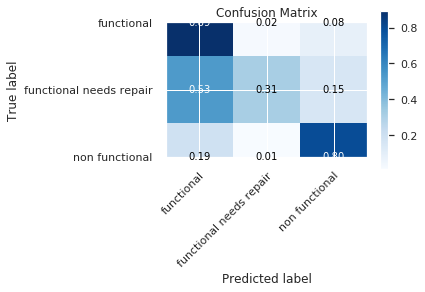

In [16]:
# Split train into train & val
train, val = train_test_split(trainw, train_size=0.80, test_size=0.20, 
                              stratify=trainw['status_group'], random_state=42)

eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

n_estimators = 700
max_depth = 20

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(n_estimators=n_estimators,
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
y_pred = pipeline.predict(X_val)
eda.get_acc_rec_fone(y_val, y_pred, verbose=True, title='VAL')
y_pred = pipeline.predict(X_val)
eda.plot_confusion_matrix(y_val, y_pred, classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

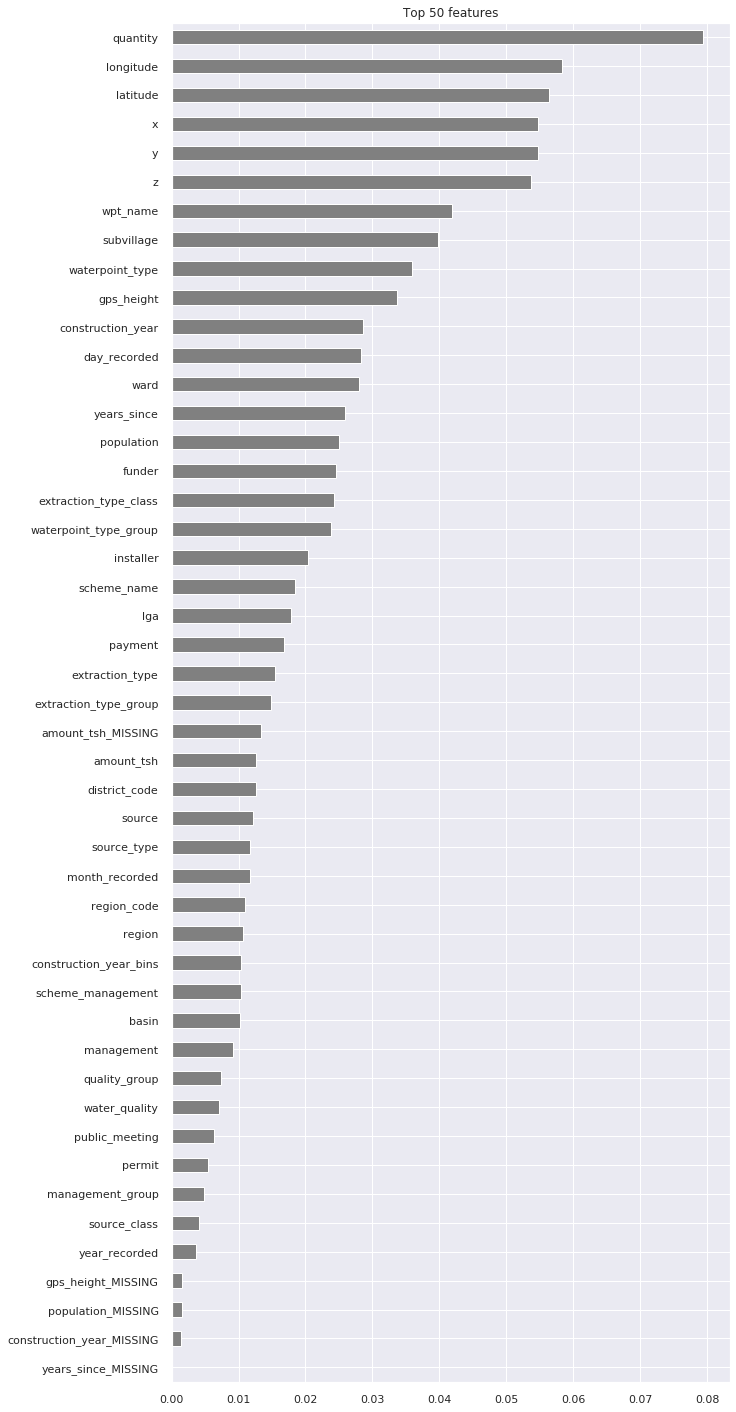

In [21]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [22]:
target = 'status_group'
X_train = trainw.drop(columns=target)
y_train = trainw[target]
X_test = testw

n_estimators = 700
max_depth = 20

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(n_estimators=n_estimators,
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
eda.get_acc_rec_fone(y_train, y_pred, verbose=True, title='TRAIN')
kaggle_submission(pipeline, X_test, sampledf)

-------- TRAIN SET --------
Accuracy Score: 1.0000
                         Precision    Recall   F Score  Support
functional                1.000000  0.999969  0.999985    32259
non functional            0.999768  1.000000  0.999884     4317
functional needs repair   1.000000  1.000000  1.000000    22824


In [ ]:
set_id_as_index = True
add_years_since = True
drop_cols = False
clean_cat_cols = False 
clean_num_cols = False
fix_null_island = True
num_missing_value_feature = False
cat_missing_value_feature = False
convert_lat_lon = True
cut_construction_year = True
cut_gps_height = False

trainw = wrangle(traindf, set_id_as_index=set_id_as_index, add_years_since=add_years_since, 
                drop_cols=drop_cols, clean_cat_cols=clean_cat_cols, 
            clean_num_cols=clean_num_cols, fix_null_island=fix_null_island, 
            num_missing_value_feature=num_missing_value_feature,
                cat_missing_value_feature=cat_missing_value_feature, 
                convert_lat_lon=convert_lat_lon,
               cut_construction_year=cut_construction_year, cut_gps_height=cut_gps_height)

testw = wrangle(testdf, set_id_as_index=set_id_as_index, add_years_since=add_years_since, drop_cols=drop_cols, clean_cat_cols=clean_cat_cols, 
            clean_num_cols=clean_num_cols, fix_null_island=fix_null_island, 
            num_missing_value_feature=num_missing_value_feature,
               cat_missing_value_feature=cat_missing_value_feature, 
               convert_lat_lon=convert_lat_lon,
              cut_construction_year=cut_construction_year, cut_gps_height=cut_gps_height)


# Split train into train & val
train, val = train_test_split(trainw, train_size=0.80, test_size=0.20, 
                              stratify=trainw['status_group'], random_state=42)

eda.print_shape(train, val, title='After Train/Val SPLIT')

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 1000), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, 25, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

In [ ]:
def target_encode_cat(df, cat_cols, target):
    
    df = df.copy()
    X_f = df[cat_cols].drop(columns=target)
    X_nf = df[cat_cols].drop(columns=target)
    X_fr = df[cat_cols].drop(columns=target)
    
    
    df_encoded = encoder.fit_transform(X_train, y_train)
    
    




